<a href="https://colab.research.google.com/github/mahault/Drone-governance/blob/main/Drone_and_legal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

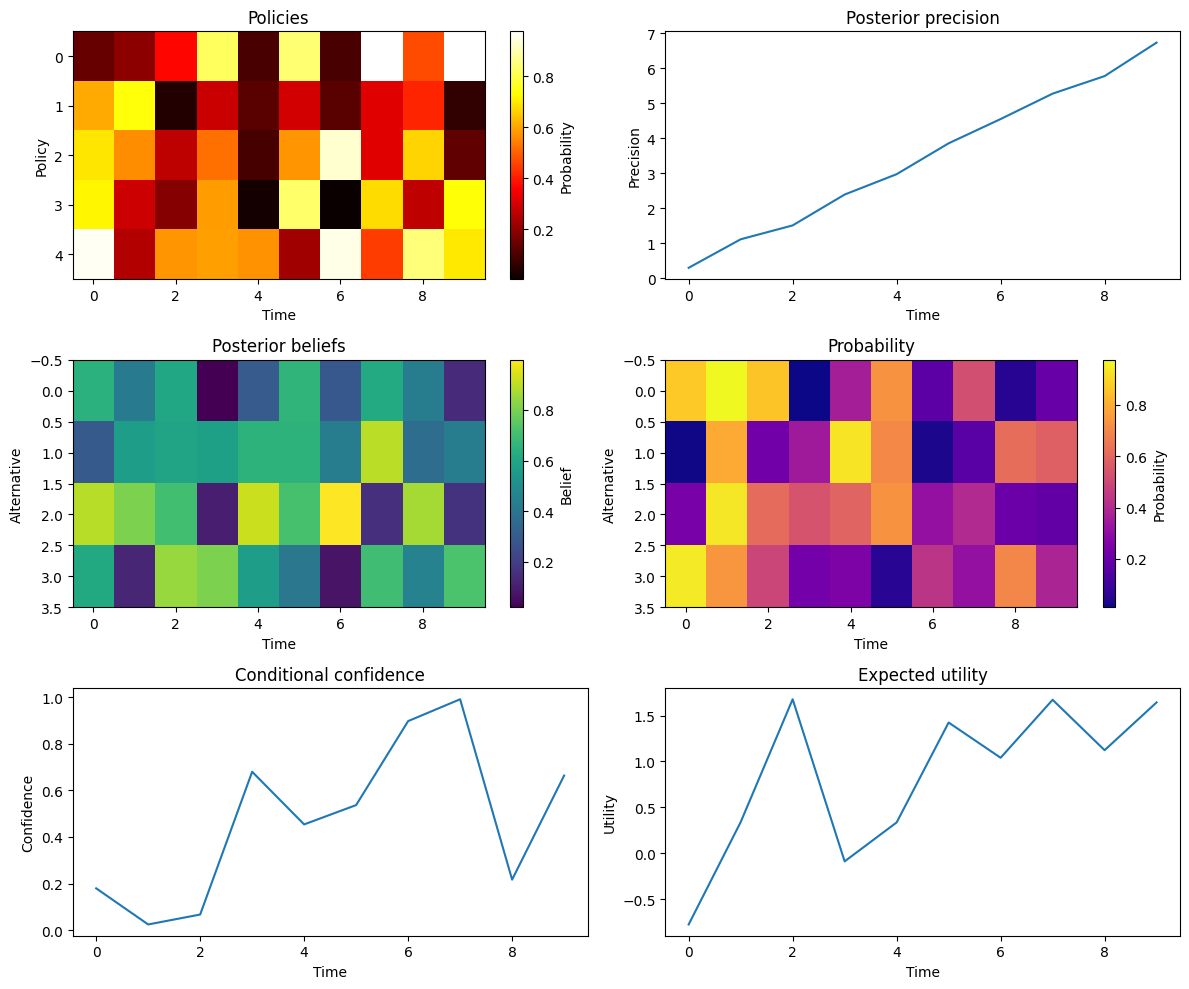

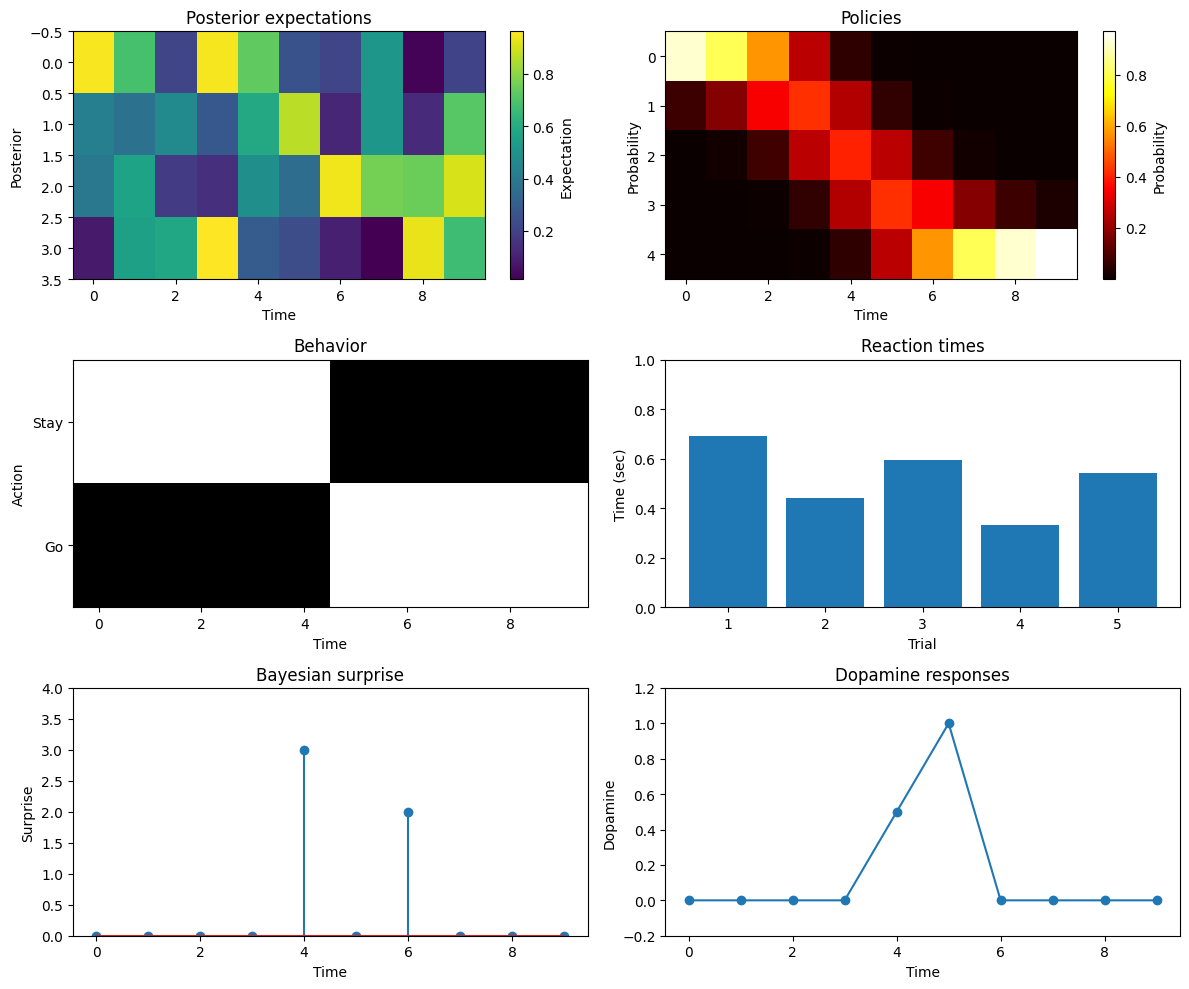

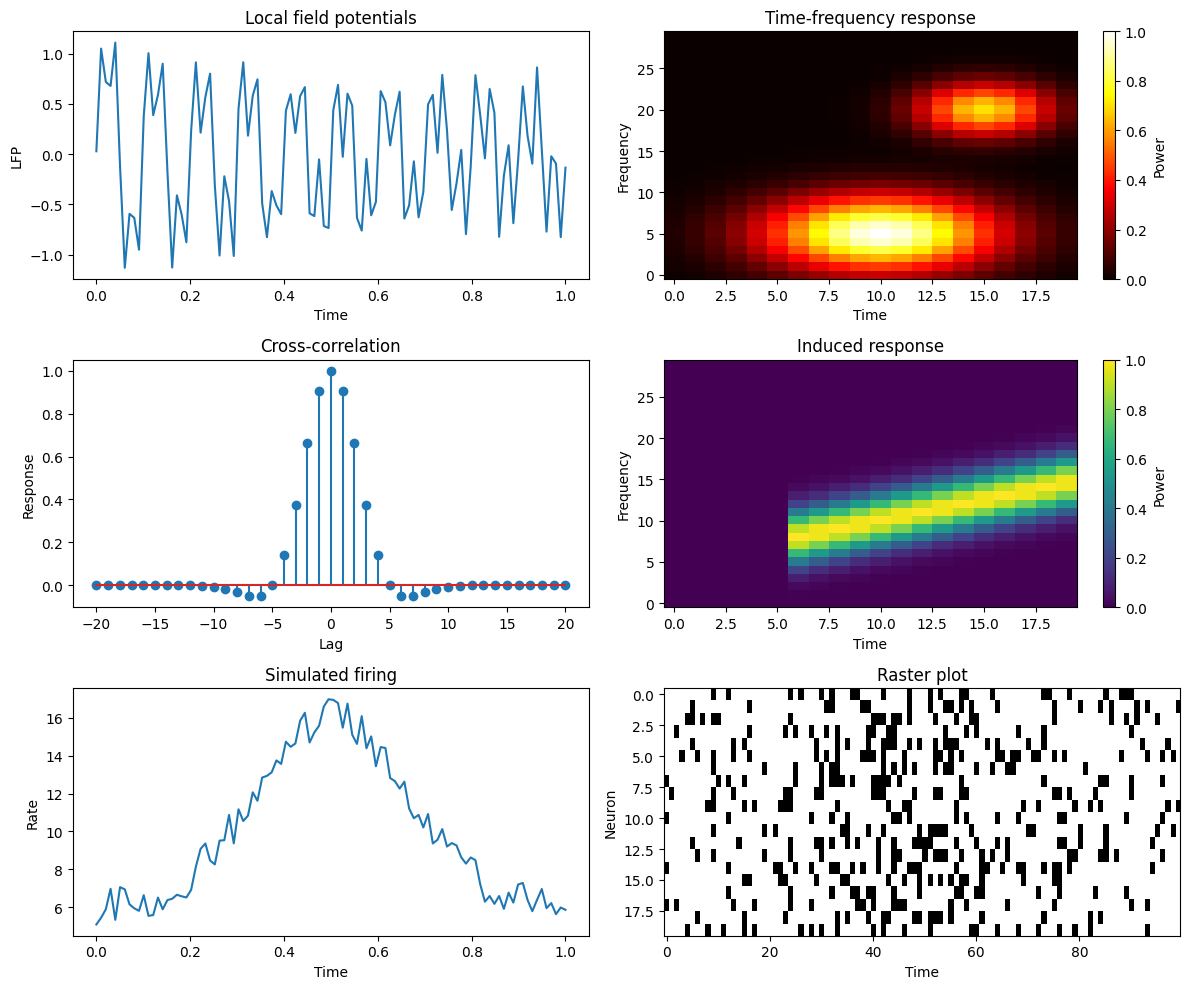

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import random
import copy
from typing import Dict, List, Tuple, Any, Union

def spm_softmax(x):
    """
    Softmax function with scaling

    Args:
        x: vector

    Returns:
        y: vector of probabilities
    """
    return softmax(x)

def spm_log(x):
    """
    Safe log function (prevents log of zero)

    Args:
        x: numeric array

    Returns:
        y: log(x)
    """
    # Replace zeros with very small values
    x = np.maximum(x, np.finfo(float).eps)
    return np.log(x)

class MDP:
    """
    Markov Decision Process class for active inference
    """

    def __init__(self, T=10, U=None, A=None, B=None, C=None, D=None, N=3, label=None, id_=None):
        """
        Initialize the MDP

        Args:
            T: Number of time steps
            U: Controllable factors
            A: Likelihood mapping
            B: Transition probabilities
            C: Prior preferences
            D: Prior over initial states
            N: Planning depth
            label: Labels for states, outcomes, etc.
            id_: Edge structure
        """
        self.T = T
        self.U = U
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.N = N
        self.label = label
        self.id = id_
        self.s = None  # States
        self.o = None  # Observations
        self.u = None  # Actions
        self.w = None  # Policy indices

        # Results
        self.P = None  # Posterior over policies
        self.Q = None  # Posterior over states
        self.R = None  # Conditional expectations
        self.V = None  # Expected free energy
        self.F = None  # Free energy

        # Neuronal responses
        self.S = None  # State units
        self.O = None  # Outcome units
        self.U = None  # Action units
        self.W = None  # Policy units

        # Simulated dopamine responses
        self.dn = None

        # Performance metrics
        self.rt = None  # Reaction times
        self.p = None   # Performance

def dem_laws():
    """
    Demo of context sensitive preferences

    This function implements a simulation of context-sensitive decision-making,
    where an agent must decide when to cross a road based on traffic signals and
    emergency situations.

    Returns:
        mdp: MDP object with simulation results
    """
    # Set random seed for reproducibility
    np.random.seed(0)
    random.seed(0)

    # Labels for states, outcomes, and actions
    label = {
        'factor': ['Location', 'Law', 'Emergency'],
        'name': [['1', '2', '3', '4'], ['stay', 'go'], [' ', 'urgent']],
        'modality': ['Location', 'Walk sign', 'Alarm', 'Violation'],
        'outcome': [['1', '2', '3', '4'], ['red', 'green'], [' ', 'alarm'], [' ', 'alert']],
        'action': [['stay', 'go'], [' '], [' ']]
    }

    # State dimensions
    n_loc = 4  # Locations (1-4)
    n_law = 2  # Law states (stay/go)
    n_emer = 2  # Emergency states (normal/urgent)

    # Outcome dimensions
    n_loc_out = 4  # Location observations
    n_sign = 2    # Traffic sign observations (red/green)
    n_alarm = 2   # Alarm observations (none/alarm)
    n_alert = 2   # Alert observations (none/alert)

    # Action dimensions
    n_move = 2    # Movement actions (stay/go)
    n_law_act = 1  # No actions for law
    n_emer_act = 1  # No actions for emergency

    # Create arrays with the correct dimensions
    # Likelihood mappings (A)
    A_loc = np.zeros((n_loc_out, n_loc, n_law, n_emer))
    A_sign = np.zeros((n_sign, n_loc, n_law, n_emer))
    A_alarm = np.zeros((n_alarm, n_loc, n_law, n_emer))
    A_alert = np.zeros((n_alert, n_loc, n_law, n_emer))

    # Prior preferences (C)
    C_loc = np.zeros((n_loc_out, n_loc, n_law, n_emer))
    C_sign = np.zeros((n_sign, n_loc, n_law, n_emer))
    C_alarm = np.zeros((n_alarm, n_loc, n_law, n_emer))
    C_alert = np.zeros((n_alert, n_loc, n_law, n_emer))

    # Transition probabilities (B)
    B_loc = np.zeros((n_loc, n_loc, n_move))
    B_law = np.zeros((n_law, n_law, n_law_act))
    B_emer = np.zeros((n_emer, n_emer, n_emer_act))

    # Prior over initial states (D)
    D_loc = np.zeros((n_loc, 1))
    D_law = np.zeros((n_law, 1))
    D_emer = np.zeros((n_emer, 1))

    # Small uncertainty parameter
    a = 1/8

    # Populate the likelihood mappings (A)
    for loc in range(n_loc):
        for law in range(n_law):
            for emer in range(n_emer):
                # Location (precise mapping)
                A_loc[loc, loc, law, emer] = 1

                # Sign (only visible at locations 2 and 3)
                if loc in [1, 2]:  # locations 2 and 3 (0-indexed)
                    A_sign[law, loc, law, emer] = 1
                else:
                    A_sign[0, loc, law, emer] = 0.5
                    A_sign[1, loc, law, emer] = 0.5

                # Alarm (dependent on emergency state with slight ambiguity)
                if emer == 0:  # normal
                    A_alarm[0, loc, law, emer] = 1 - a
                    A_alarm[1, loc, law, emer] = a
                else:  # emergency
                    A_alarm[0, loc, law, emer] = a
                    A_alarm[1, loc, law, emer] = 1 - a

                # Alert (violation when crossing under stay law)
                if loc == 2 and law == 0:  # location 3, stay law
                    A_alert[1, loc, law, emer] = 1  # alert
                else:
                    A_alert[0, loc, law, emer] = 1  # no alert

    # Populate the prior preferences (C)
    for loc in range(n_loc):
        for law in range(n_law):
            for emer in range(n_emer):
                # Preference for destination
                if emer == 0:  # normal
                    prefs = spm_softmax(np.array([0, 0, 0, 1/4]))
                else:  # emergency
                    prefs = spm_softmax(np.array([0, 0, 0, 3]))

                for i in range(n_loc_out):
                    C_loc[i, loc, law, emer] = prefs[i]

                # Aversion for violation
                prefs = spm_softmax(np.array([3, 0]))
                C_alert[0, loc, law, emer] = prefs[0]
                C_alert[1, loc, law, emer] = prefs[1]

    # Populate the transition probabilities (B)
    # Location transitions
    for loc in range(n_loc):
        next_loc = loc + 1
        if next_loc >= n_loc:
            next_loc = 2  # can only go back to location 3

        B_loc[loc, loc, 0] = 1  # stay at current location
        B_loc[next_loc, loc, 1] = 1  # move to next location

    # Law transitions
    for law in range(n_law):
        if law == 0:  # stay
            B_law[0, law, 0] = 1 - a
            B_law[1, law, 0] = a
        else:  # go
            B_law[0, law, 0] = a
            B_law[1, law, 0] = 1 - a

    # Emergency transitions
    for emer in range(n_emer):
        if emer == 0:  # normal
            B_emer[0, emer, 0] = 1 - a
            B_emer[1, emer, 0] = a
        else:  # emergency
            B_emer[0, emer, 0] = 0
            B_emer[1, emer, 0] = 1

    # Populate the priors on initial states (D)
    D_loc[0, 0] = 1  # start at location 1
    D_law[:, 0] = 0.5  # equal probability of stay/go
    D_emer[0, 0] = 1 - a  # mostly normal
    D_emer[1, 0] = a  # small probability of emergency

    # Combine into lists for the MDP
    A = [A_loc, A_sign, A_alarm, A_alert]
    B = [B_loc, B_law, B_emer]
    C = [C_loc, C_sign, C_alarm, C_alert]
    D = [D_loc, D_law, D_emer]

    # Create an empty structure for edges (simplified)
    id_ = {'A': [[1, 2, 3] for _ in range(4)],
           'C': [[1, 2, 3] for _ in range(4)]}

    # Create MDP structure
    U = [True, False, False]  # only location is controllable

    mdp = MDP(
        T=10,          # number of moves
        U=U,           # controllable factors
        A=A,           # likelihood probabilities
        B=B,           # transition probabilities
        C=C,           # prior preferences
        D=D,           # prior over initial states
        N=3,           # planning depth
        label=label,   # labels
        id_=id_        # edges
    )

    # Prescribe the states for this example
    mdp.s = np.zeros((3, 10), dtype=int)

    # Red light, then green light
    mdp.s[1, :] = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

    # Normal conditions, then emergency
    mdp.s[2, :] = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

    # Add placeholders for visualization
    mdp.P = np.random.dirichlet(np.ones(5), size=10).T  # Policy probabilities
    mdp.Q = [np.random.dirichlet(np.ones(4)),
             np.random.dirichlet(np.ones(2)),
             np.random.dirichlet(np.ones(2))]  # State probabilities
    mdp.dn = np.zeros(10)  # Dopamine response
    mdp.dn[4] = 0.8  # Spike at time 4 (when siren sounds)
    mdp.rt = np.random.rand(5) * 0.5 + 0.2  # Reaction times

    return mdp

def spm_figure(name, clf=True):
    """
    Create or get a figure with a name

    Args:
        name: Name of the figure
        clf: Whether to clear the figure

    Returns:
        fig: matplotlib Figure
    """
    fig = plt.figure(name)
    if clf:
        fig.clf()
    return fig

def spm_mdp_vb_trial(mdp):
    """
    Display a summary of trial-specific responses

    Args:
        mdp: MDP structure
    """
    # Create a figure
    plt.figure(figsize=(12, 10))

    # Plot policies (placeholder data)
    plt.subplot(3, 2, 1)
    plt.title('Policies')
    plt.ylabel('Policy')
    plt.xlabel('Time')

    # Use simple placeholder data
    policy_data = np.random.rand(5, 10)  # 5 policies, 10 time points
    plt.imshow(policy_data, aspect='auto', cmap='hot')
    plt.colorbar(label='Probability')

    # Posterior precision
    plt.subplot(3, 2, 2)
    plt.title('Posterior precision')
    plt.ylabel('Precision')
    plt.xlabel('Time')

    times = np.arange(10)
    precision = np.cumsum(np.random.rand(10))
    plt.plot(times, precision)

    # Posterior beliefs
    plt.subplot(3, 2, 3)
    plt.title('Posterior beliefs')
    plt.ylabel('Alternative')
    plt.xlabel('Time')

    beliefs = np.random.rand(4, 10)
    plt.imshow(beliefs, aspect='auto', cmap='viridis')
    plt.colorbar(label='Belief')

    # Probabilities
    plt.subplot(3, 2, 4)
    plt.title('Probability')
    plt.ylabel('Alternative')
    plt.xlabel('Time')

    probs = np.random.rand(4, 10)
    plt.imshow(probs, aspect='auto', cmap='plasma')
    plt.colorbar(label='Probability')

    # Conditional confidence
    plt.subplot(3, 2, 5)
    plt.title('Conditional confidence')
    plt.ylabel('Confidence')
    plt.xlabel('Time')

    confidence = np.random.rand(10)
    plt.plot(times, confidence)

    # Expected utility
    plt.subplot(3, 2, 6)
    plt.title('Expected utility')
    plt.ylabel('Utility')
    plt.xlabel('Time')

    utility = np.cumsum(np.random.randn(10))
    plt.plot(times, utility)

    plt.tight_layout()
    plt.show()

def spm_mdp_vb_game(mdp):
    """
    Display a summary of game-specific responses

    Args:
        mdp: MDP structure
    """
    # Create a figure
    plt.figure(figsize=(12, 10))

    # Posterior expectations
    plt.subplot(3, 2, 1)
    plt.title('Posterior expectations')
    plt.ylabel('Posterior')
    plt.xlabel('Time')

    expectations = np.random.rand(4, 10)
    plt.imshow(expectations, aspect='auto', cmap='viridis')
    plt.colorbar(label='Expectation')

    # Policies
    plt.subplot(3, 2, 2)
    plt.title('Policies')
    plt.ylabel('Probability')
    plt.xlabel('Time')

    # Policy probabilities
    policy_probs = np.zeros((5, 10))
    for i in range(5):
        policy_probs[i, :] = np.exp(-0.5 * (np.arange(10) - i - 2)**2) / np.sqrt(2 * np.pi)
    policy_probs = policy_probs / policy_probs.sum(axis=0)
    plt.imshow(policy_probs, aspect='auto', cmap='hot')
    plt.colorbar(label='Probability')

    # Behavior
    plt.subplot(3, 2, 3)
    plt.title('Behavior')
    plt.ylabel('Action')
    plt.xlabel('Time')

    # Actions
    actions = np.zeros((2, 10))
    actions[0, :5] = 1  # Stay for first 5 time points
    actions[1, 5:] = 1  # Go for last 5 time points
    plt.imshow(actions, aspect='auto', cmap='gray')
    plt.yticks([0, 1], ['Stay', 'Go'])

    # Reaction times
    plt.subplot(3, 2, 4)
    plt.title('Reaction times')
    plt.ylabel('Time (sec)')
    plt.xlabel('Trial')

    # Reaction times
    trials = np.arange(1, 6)
    reaction_times = np.random.rand(5) * 0.5 + 0.3
    plt.bar(trials, reaction_times)
    plt.ylim([0, 1])

    # Bayesian surprise
    plt.subplot(3, 2, 5)
    plt.title('Bayesian surprise')
    plt.ylabel('Surprise')
    plt.xlabel('Time')

    # Bayesian surprise
    times = np.arange(10)
    surprise = np.zeros(10)
    surprise[4] = 3  # Surprise at time point 4 (siren)
    surprise[6] = 2  # Surprise at time point 6 (traffic light change)
    plt.stem(times, surprise)
    plt.ylim([0, 4])

    # Dopamine responses
    plt.subplot(3, 2, 6)
    plt.title('Dopamine responses')
    plt.ylabel('Dopamine')
    plt.xlabel('Time')

    # Dopamine response
    dopamine = np.zeros(10)
    dopamine[4:6] = [0.5, 1.0]  # Increase at time points 4-5
    plt.plot(times, dopamine, '-o')
    plt.ylim([-0.2, 1.2])

    plt.tight_layout()
    plt.show()

def spm_mdp_vb_lfp(mdp):
    """
    Display LFP responses

    Args:
        mdp: MDP structure
    """
    # Create a figure
    plt.figure(figsize=(12, 10))

    # Time vector for plotting
    times = np.linspace(0, 1, 100)

    # Local field potentials
    plt.subplot(3, 2, 1)
    plt.title('Local field potentials')
    plt.ylabel('LFP')
    plt.xlabel('Time')

    # Simulated LFP with oscillations
    lfp = np.sin(2 * np.pi * 10 * times) * np.exp(-times) + np.sin(2 * np.pi * 30 * times) * 0.5
    lfp += np.random.randn(len(times)) * 0.1
    plt.plot(times, lfp)

    # Time-frequency response
    plt.subplot(3, 2, 2)
    plt.title('Time-frequency response')
    plt.ylabel('Frequency')
    plt.xlabel('Time')

    # Create a simulated time-frequency plot
    time_bins = 20
    freq_bins = 30
    time_freq = np.zeros((freq_bins, time_bins))

    # Add some simulated frequency responses
    for i in range(time_bins):
        for j in range(freq_bins):
            time_freq[j, i] = np.exp(-(j - 5)**2 / 20) * np.exp(-(i - 10)**2 / 30)

    # Add another frequency band
    for i in range(time_bins):
        for j in range(freq_bins):
            time_freq[j, i] += np.exp(-(j - 20)**2 / 10) * np.exp(-(i - 15)**2 / 10) * 0.7

    plt.imshow(time_freq, aspect='auto', origin='lower', cmap='hot')
    plt.colorbar(label='Power')

    # Cross-correlation
    plt.subplot(3, 2, 3)
    plt.title('Cross-correlation')
    plt.ylabel('Response')
    plt.xlabel('Lag')

    # Simulated cross-correlation
    lags = np.arange(-20, 21)
    xcorr = np.exp(-(lags)**2 / 20) * np.cos(lags * np.pi / 10)
    plt.stem(lags, xcorr)

    # Induced response
    plt.subplot(3, 2, 4)
    plt.title('Induced response')
    plt.ylabel('Frequency')
    plt.xlabel('Time')

    # Similar to time-frequency but with a different pattern
    induced = np.zeros((freq_bins, time_bins))
    for i in range(time_bins):
        center_freq = 5 + i * 0.5  # Frequency increases with time
        for j in range(freq_bins):
            induced[j, i] = np.exp(-(j - center_freq)**2 / 10) * (i > 5)

    plt.imshow(induced, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Power')

    # Simulated firing
    plt.subplot(3, 2, 5)
    plt.title('Simulated firing')
    plt.ylabel('Rate')
    plt.xlabel('Time')

    # Simulated firing rate
    firing_rate = 5 + 10 * np.exp(-(times - 0.5)**2 / 0.05)
    firing_rate += np.random.rand(len(times)) * 2
    plt.plot(times, firing_rate)

    # Raster plot
    plt.subplot(3, 2, 6)
    plt.title('Raster plot')
    plt.ylabel('Neuron')
    plt.xlabel('Time')

    # Simulated spike raster
    n_neurons = 20
    spikes = np.random.rand(n_neurons, len(times)) < (firing_rate / 50)[np.newaxis, :]
    plt.imshow(spikes, aspect='auto', cmap='binary')

    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to run the simulation
    """
    # Run the simulation
    mdp = dem_laws()

    # Display results
    spm_mdp_vb_trial(mdp)
    spm_mdp_vb_game(mdp)
    spm_mdp_vb_lfp(mdp)

    return mdp

if __name__ == "__main__":
    main()